## Investigating spikes in annual averages for water

In [79]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.display.max_columns = None

In [80]:
result = pd.read_csv('../data/water/CA-result-withmeasuregroup.csv')
station = pd.read_csv('../data/water/CA-station-clean.csv', low_memory=False)
data = pd.merge(result, station, left_on='LocationIdentifier', right_on='MonitoringLocationId')

sites = pd.DataFrame(np.sort(data.MonitoringLocationType.unique()))
sites['TypeGroup'] = ''
del result
del station

/Users/Sean/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
pd.options.display.max_rows = None
sites.columns = ['Type', 'TypeGroup']

sites.loc[sites.Type.str.startswith('BEACH'), 'TypeGroup'] = 'Ocean'
sites.loc[sites.Type.str.startswith('CERCLA'), 'TypeGroup'] = 'Superfund'
sites.loc[sites.Type.str.startswith('Canal'), 'TypeGroup'] = 'Surface'
sites.loc[sites.Type.str.startswith('Facility'), 'TypeGroup'] = 'Facility'
sites.loc[sites.Type.str.startswith('Lake'), 'TypeGroup'] = 'Surface'
sites.loc[sites.Type.str.startswith('Land'), 'TypeGroup'] = 'Surface'
sites.loc[sites.Type.str.startswith('Mine'), 'TypeGroup'] = 'Ground'
sites.loc[sites.Type.str.startswith('Ocean'), 'TypeGroup'] = 'Ocean'
sites.loc[sites.Type.str.startswith('Pipe'), 'TypeGroup'] = 'Facility'
sites.loc[sites.Type.str.startswith('Reservoir'), 'TypeGroup'] = 'Reservoir'
sites.loc[sites.Type.str.startswith('River/Stream'), 'TypeGroup'] = 'Surface'
sites.loc[sites.Type.str.startswith('River/stream'), 'TypeGroup'] = 'Surface'
sites.loc[sites.Type.str.startswith('Stream'), 'TypeGroup'] = 'Surface'
sites.loc[sites.Type.str.startswith('Subsurface'), 'TypeGroup'] = 'Ground'
sites.loc[sites.Type.str.startswith('Well'), 'TypeGroup'] = 'Ground'
sites.loc[sites.Type.str.startswith('Wetland'), 'TypeGroup'] = 'Surface'

sites.loc[sites.Type == 'Atmosphere', 'TypeGroup'] = 'Atmosphere'
sites.loc[sites.Type == 'Estuary', 'TypeGroup'] = 'Estuary'
sites.loc[sites.Type == 'Cave', 'TypeGroup'] = 'Ground'
sites.loc[sites.Type == 'Constructed Water Transport Structure', 'TypeGroup'] = 'Surface'
sites.loc[sites.Type == 'Channelized Stream', 'TypeGroup'] = 'Surface'
sites.loc[sites.Type == 'Other-Ground Water', 'TypeGroup'] = 'Ground'
sites.loc[sites.Type == 'Other-Surface Water', 'TypeGroup'] = 'Surface'
sites.loc[sites.Type == 'Spring', 'TypeGroup'] = 'Ground'

sites.columns = ['MonitoringLocationType', 'TypeGroup']
data = pd.merge(data, sites, on='MonitoringLocationType')

sites[sites.TypeGroup == '']

,MonitoringLocationType,TypeGroup


## Annual means and medians over time

In [82]:
data['Date'] = pd.to_datetime(data.StartDate)
data['Year'] = data.StartDate.str.split('-').str[0]


annualMeans = data.groupby(['Pollutant', 'TypeGroup', 'Year']).mean()['Value'].reset_index()
maxes = annualMeans.groupby(['Pollutant']).max()['Value'].reset_index()
maxes.columns = ['Pollutant', 'MaxValue']
annualMeans = pd.merge(annualMeans, maxes, on='Pollutant')
annualMeans['% of maximum'] = annualMeans.Value / annualMeans.MaxValue
annualMeans.describe()

,Value,MaxValue,% of maximum
count,2163.000000,2163.000000,2163.000000
mean,2.464850,72.362029,0.040435
std,14.552712,110.427722,0.137330
min,-8.666267,0.003762,-1.375598
25%,0.000798,3.075245,0.000069
50%,0.016500,10.000000,0.001750
75%,0.357909,134.689269,0.021999
max,464.000000,464.000000,1.000000


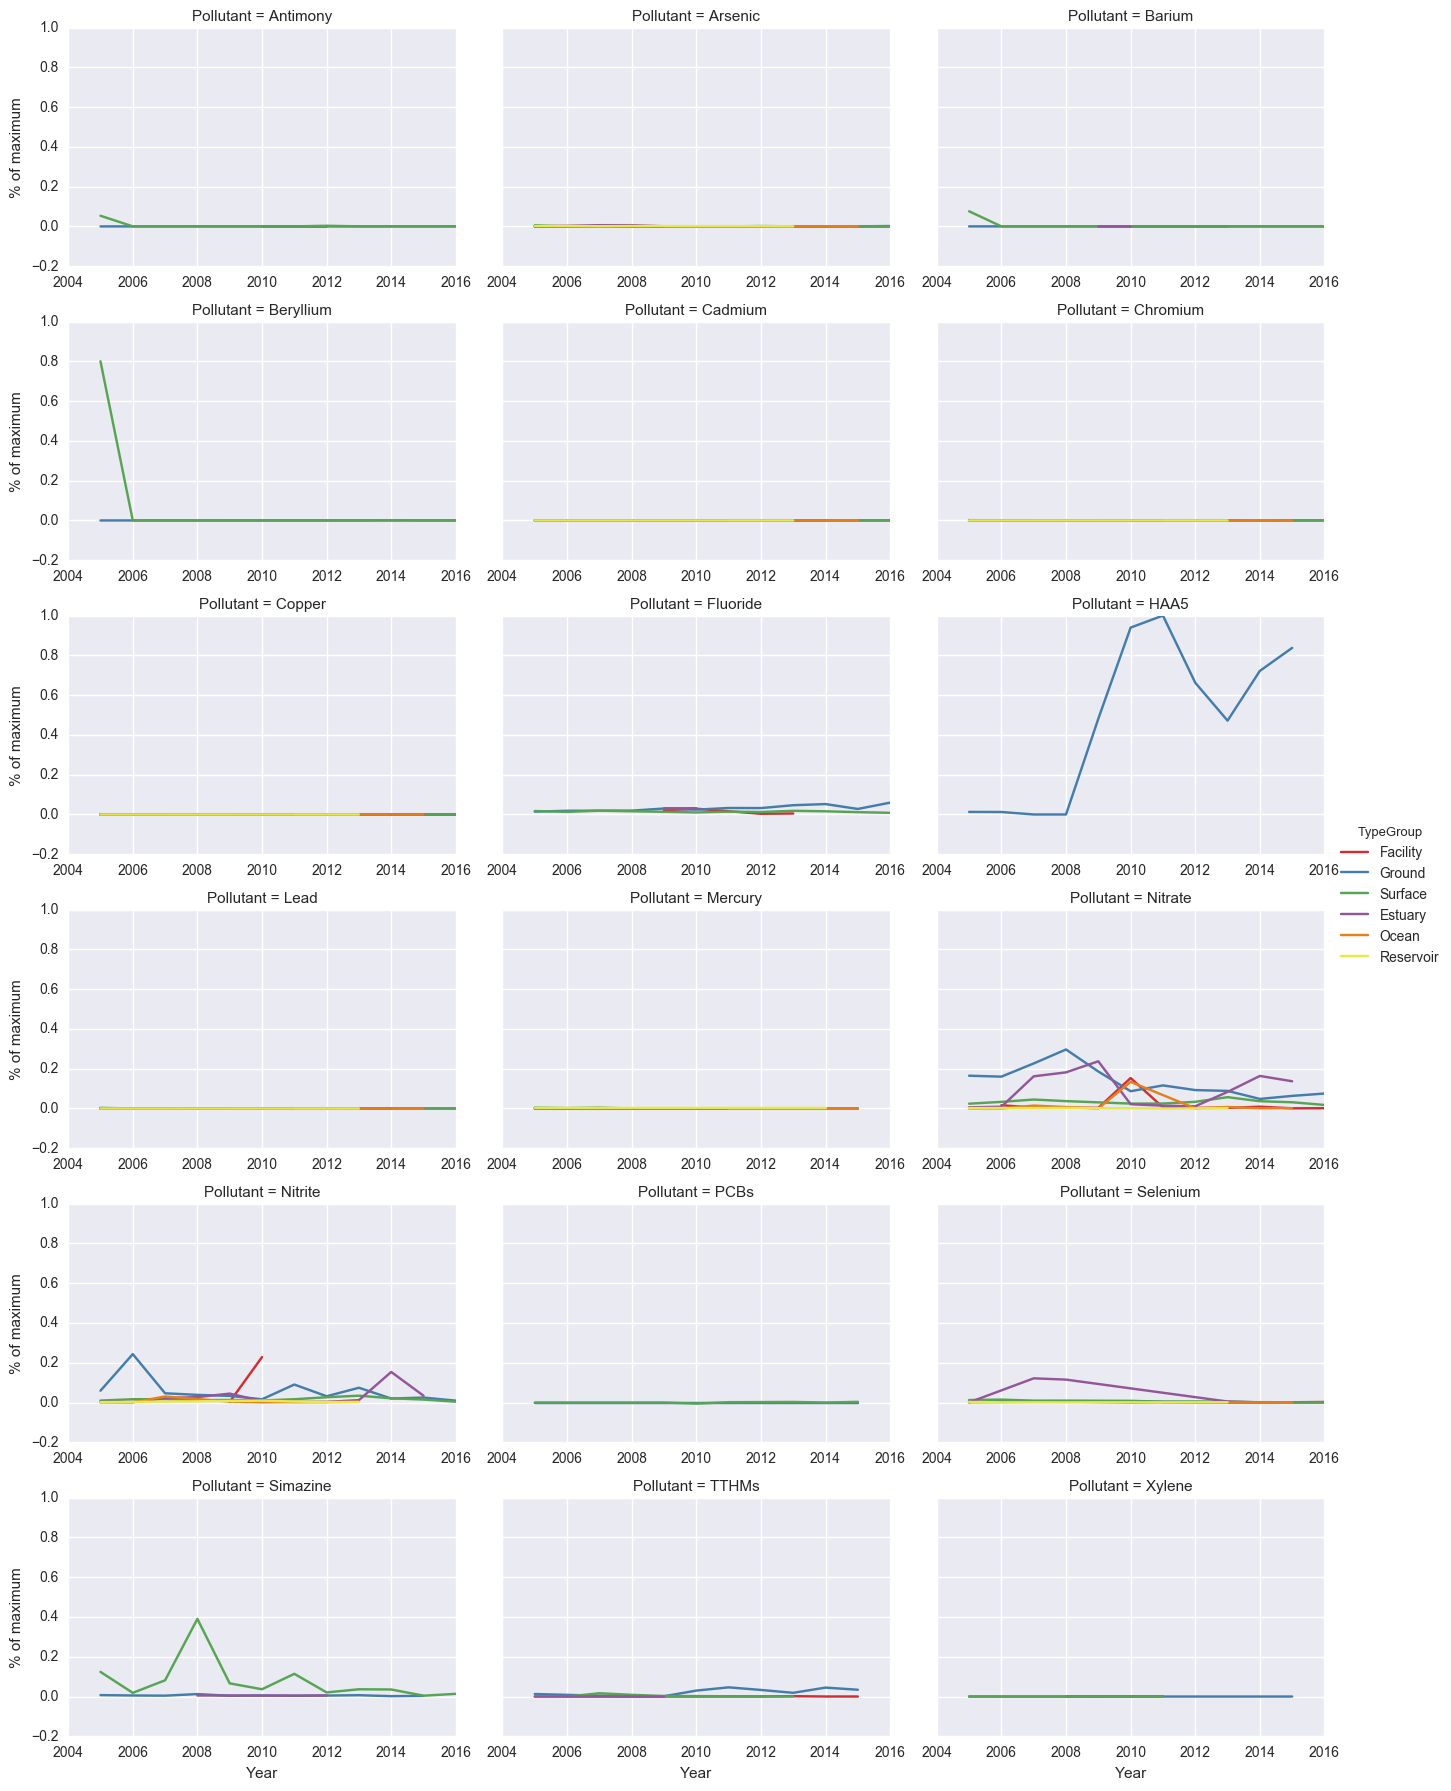

In [84]:
numcols = len(annualMeans.TypeGroup.unique())
# print(numcols)
pal = sns.color_palette('Set1', numcols, desat=.8)
# sns.palplot(pal)
sns.set_palette(pal)

grid=sns.FacetGrid(annualMeans[annualMeans.Year >= '2005'], 
                   col='Pollutant', hue='TypeGroup', 
                   col_wrap=3, sharex=False, size=3, aspect=1.5, palette=pal)
_ = grid.map(plt.plot, 'Year', '% of maximum').add_legend()

## Monthly means and medians over time

In [85]:
data['Month'] = data.StartDate.str.split('-').str[1]
data['Year-month'] = data.Year + data.Month


monthlyMeans = data.groupby(['Pollutant', 'TypeGroup', 'Year-month']).mean()['Value'].reset_index()
maxes = monthlyMeans.groupby(['Pollutant']).max()['Value'].reset_index()
maxes.columns = ['Pollutant', 'MaxValue']
monthlyMeans = pd.merge(monthlyMeans, maxes, on='Pollutant')
monthlyMeans['% of maximum'] = monthlyMeans.Value / monthlyMeans.MaxValue
monthlyMeans.describe()

,Value,MaxValue,% of maximum
count,15435.000000,15435.000000,15435.000000
mean,2.958667,190.986678,0.017785
std,17.056896,222.932318,0.074316
min,-21.527358,0.011099,-0.717579
25%,0.000701,13.200000,0.000018
50%,0.020000,30.000000,0.000501
75%,0.452786,393.000000,0.009088
max,572.515075,572.515075,1.000000


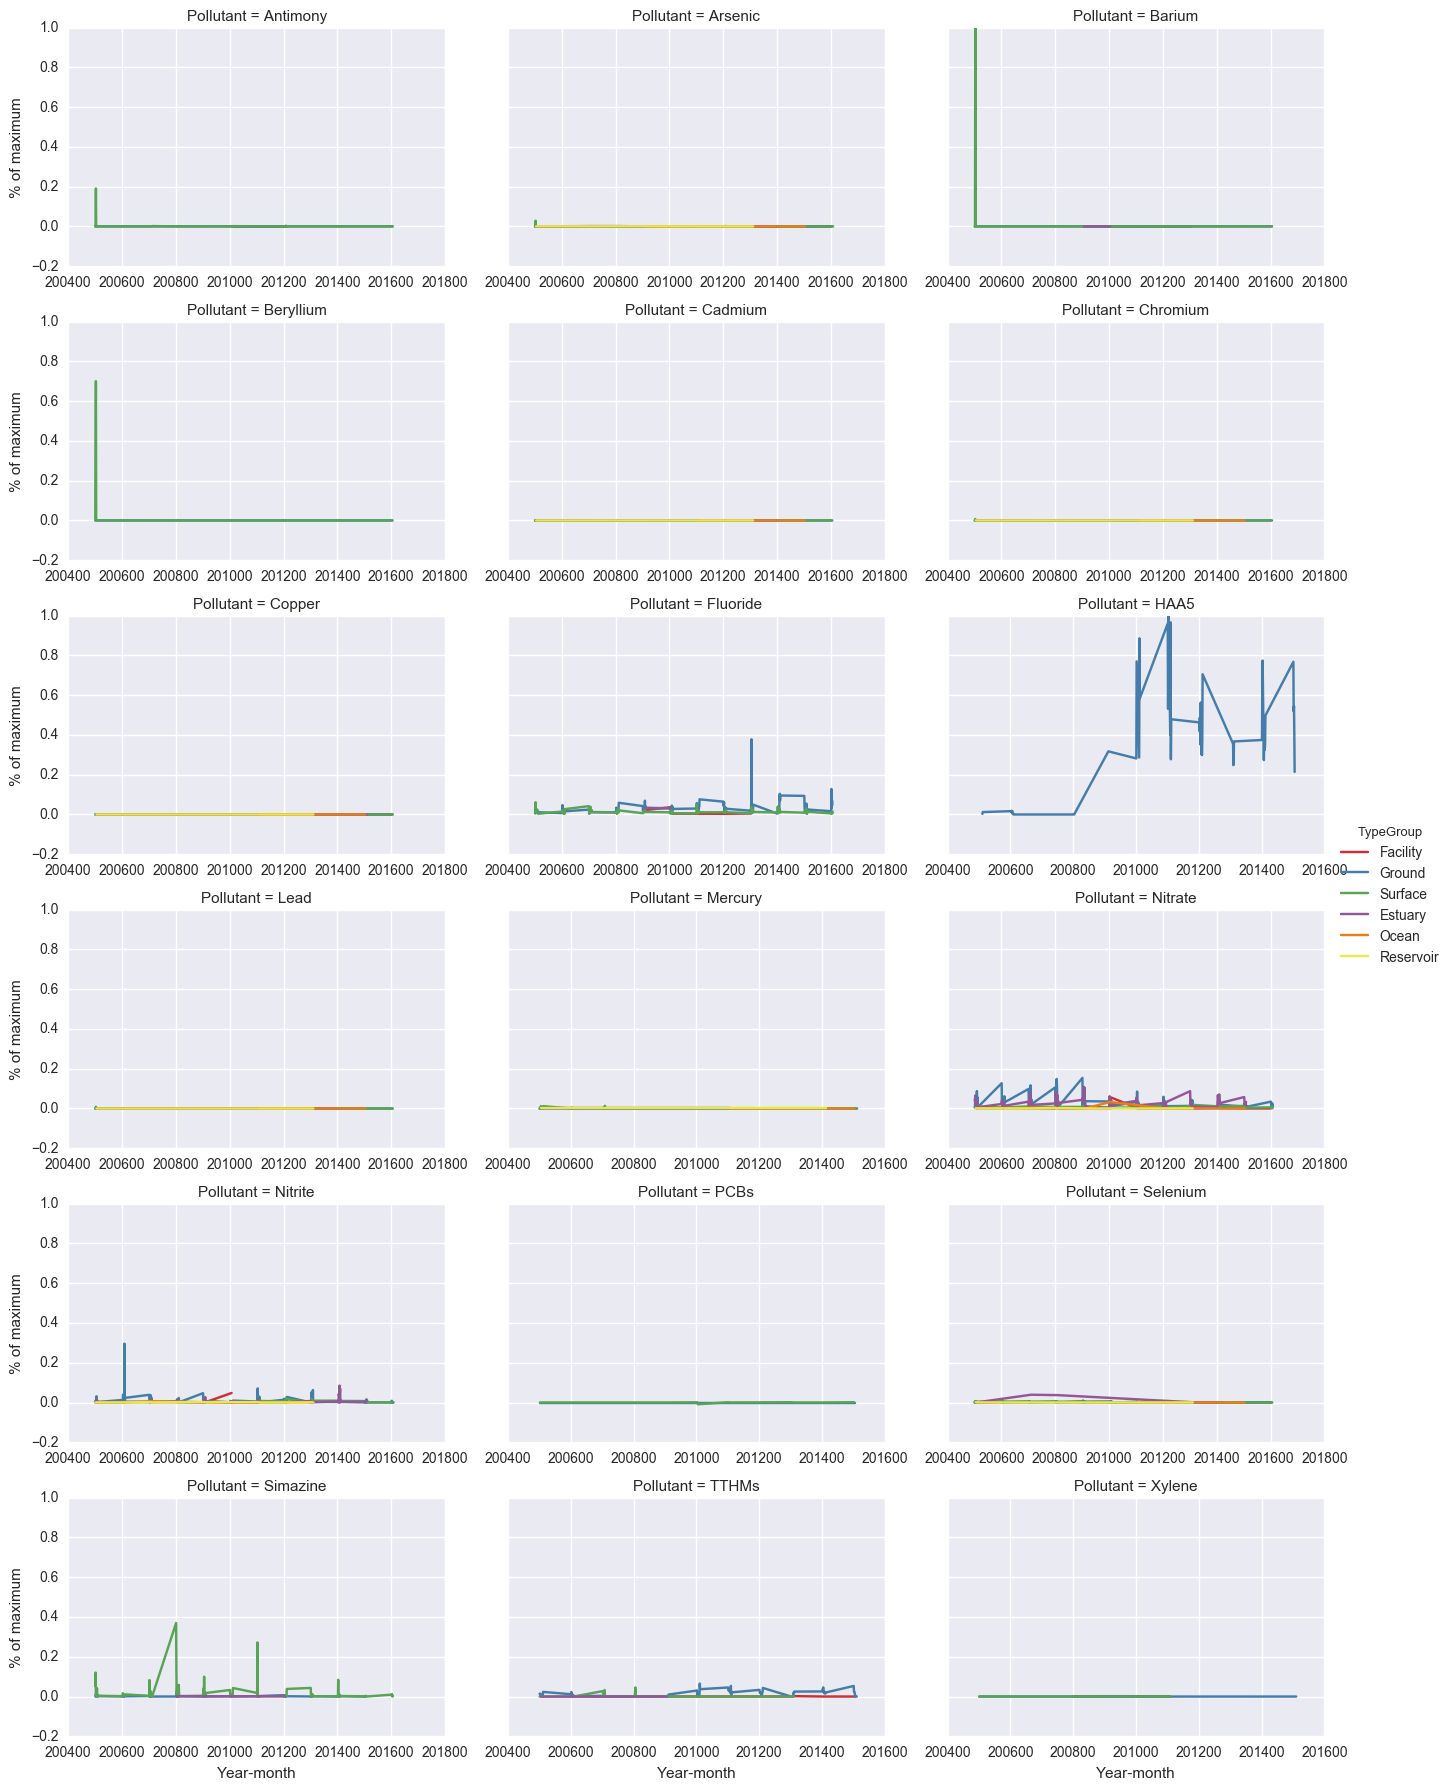

In [87]:
numcols = len(monthlyMeans.TypeGroup.unique())
# print(numcols)
pal = sns.color_palette('Set1', numcols, desat=.8)
# sns.palplot(pal)
sns.set_palette(pal)

grid=sns.FacetGrid(monthlyMeans[monthlyMeans['Year-month'] >= '200501'], 
                   col='Pollutant', hue='TypeGroup', 
                   col_wrap=3, sharex=False, size=3, aspect=1.5, palette=pal)
_ = grid.map(plt.plot, 'Year-month', '% of maximum').add_legend()

### Spikes to check:

* Antimony in surface water
* Arsenic in estuaries
* Barium in estuaries
* Copper in groundwater
* Fluoride in reservoirs
* HAA5 in groundwater
* Lead in surface water and estuaries
* Mercury in surface water
* Nitrate in groundwater and reservoirs
* Nitrite in surface water and facilities
* PCBs in surface water
* Selenium in estuaries and groundwater
* Simazine in surface water
* TTHMs in groundwater
* Xylene in groundwater

### * Antimony in surface water

This one looks like it's just very sparse data combined with some real outliers.

The outliers appear to be due to data originally being provided with incorrect units of measure, resulting in them being off by about 3 orders of magnitude.

In [36]:
asw = data[(data.Pollutant == 'Antimony') & (data.TypeGroup == 'Surface')]
print("Number of measurements: {}".format(len(asw)))
print("Number of nonzero measurements: {}".format(len(asw[asw.Value > 0])))

asw.describe()

Number of measurements: 701
Number of nonzero measurements: 701


/Users/Sean/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Mclg,Mcl,Value,ExceedsMclg,HUC,DrainageArea,ContributingDrainageArea,Latitude,Longitude,VerticalMeasure,StateCode,CountyCode
count,7.010000e+02,7.010000e+02,701.000000,701.000000,6.670000e+02,326.000000,200.000000,701.000000,701.000000,367.000000,701.0,701.000000
mean,6.000000e-03,6.000000e-03,0.022109,0.047076,1.701150e+07,119367.921319,181513.000000,34.951239,-117.374288,1635.887793,6.0,57.248217
std,8.940205e-17,8.940205e-17,0.198157,0.211952,1.426589e+06,90558.019764,2905.968732,2.397138,2.848531,2373.349909,0.0,24.750666
min,6.000000e-03,6.000000e-03,0.000028,0.000000,1.503010e+07,0.270000,178700.000000,32.608833,-123.673668,-57.000000,6.0,1.000000
25%,6.000000e-03,6.000000e-03,0.000162,0.000000,NaN,NaN,NaN,32.883654,-118.832631,NaN,6.0,37.000000
50%,6.000000e-03,6.000000e-03,0.000270,0.000000,NaN,NaN,NaN,34.295570,-117.007804,NaN,6.0,71.000000
75%,6.000000e-03,6.000000e-03,0.000490,0.000000,NaN,NaN,NaN,37.622500,-114.467448,NaN,6.0,73.000000
max,6.000000e-03,6.000000e-03,4.100000,1.000000,1.810020e+07,246500.000000,184500.000000,41.972366,-114.139443,8582.000000,6.0,113.000000


The distribution is heavily skewed. The MCL is 0.006, and the 4th quartile is .0004.  Let's take a look at the data points that exceed 0.006:

In [39]:
high_vals = asw[asw.Value > asw.Mcl]
print("Number of values exceeding MCL: {}".format(len(high_vals)))
high_vals.describe()

Number of values exceeding MCL: 33


/Users/Sean/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Mclg,Mcl,Value,ExceedsMclg,HUC,DrainageArea,ContributingDrainageArea,Latitude,Longitude,VerticalMeasure,StateCode,CountyCode
count,3.300000e+01,3.300000e+01,33.000000,33.0,3.300000e+01,19.000000,10.0,33.000000,33.000000,23.000000,33.0,33.000000
mean,6.000000e-03,6.000000e-03,0.458967,1.0,1.716166e+07,99401.915789,184500.0,34.949544,-117.076373,3723.913043,6.0,39.848485
std,2.642430e-18,2.642430e-18,0.807714,0.0,1.427309e+06,96493.525698,0.0,1.826259,1.881168,2515.683838,0.0,13.829591
min,6.000000e-03,6.000000e-03,0.006220,1.0,1.503010e+07,68.300000,184500.0,32.883654,-118.817631,262.000000,6.0,25.000000
25%,6.000000e-03,6.000000e-03,0.011400,1.0,1.503010e+07,NaN,NaN,32.883654,-118.405233,NaN,6.0,25.000000
50%,6.000000e-03,6.000000e-03,0.030000,1.0,1.809010e+07,NaN,NaN,34.797683,-118.405067,NaN,6.0,37.000000
75%,6.000000e-03,6.000000e-03,0.800000,1.0,1.809021e+07,NaN,NaN,35.848577,-114.467448,NaN,6.0,51.000000
max,6.000000e-03,6.000000e-03,4.100000,1.0,1.809021e+07,188500.000000,184500.0,37.668822,-114.467448,6950.000000,6.0,71.000000


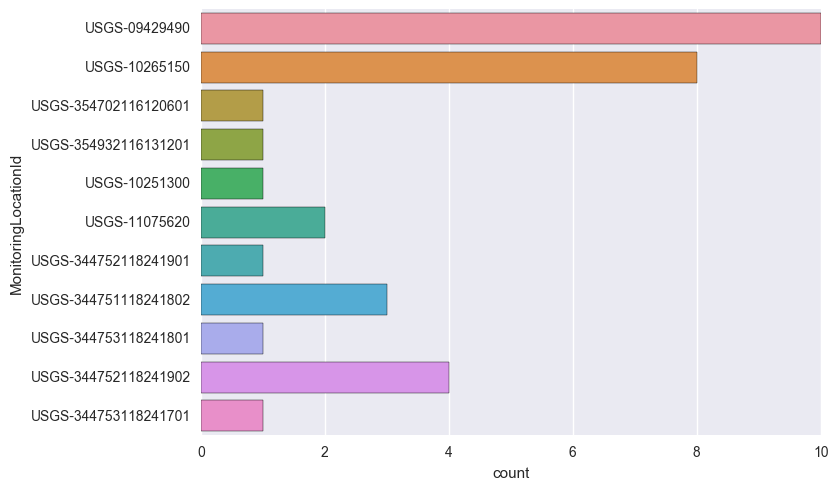

In [52]:
sns.countplot(y=high_vals.MonitoringLocationId)

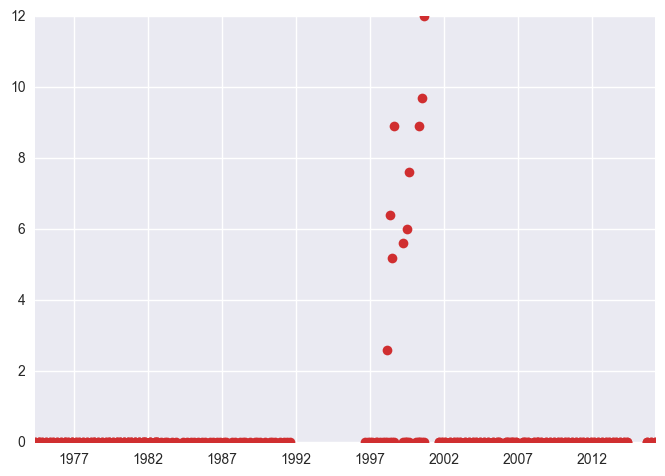

In [74]:
siteData = pd.DataFrame(data[(data.MonitoringLocationId.isin(['USGS-09429490'])) 
                             & (data.Pollutant=='Arsenic')])
_, ax = plt.subplots()
ax.plot_date(siteData.Date, siteData.Value)

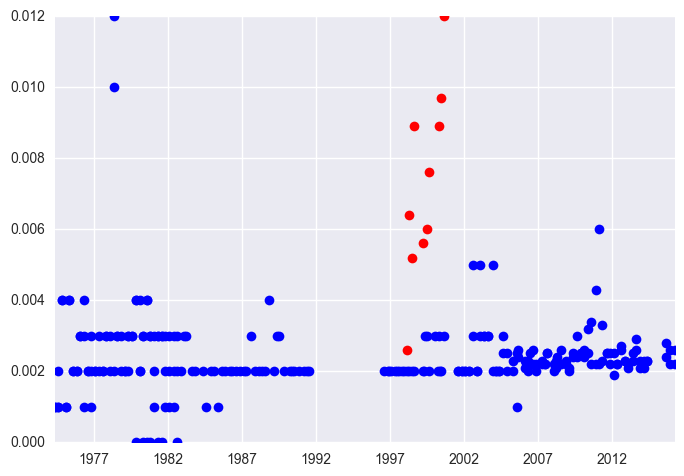

In [75]:
siteData['IsOutlier'] = siteData.Value > 1
siteData.loc[siteData.Value > 2, 'Value'] /= 1000
asis = siteData[siteData.IsOutlier == False]
edited = siteData[siteData.IsOutlier]
_, ax = plt.subplots()
ax.plot_date(asis.Date, asis.Value, c='b')
ax.plot_date(edited.Date, edited.Value, c='r')

In [65]:
asis

,LocationIdentifier,Medium,MediumSubdivision,StartDate,StartTime,TimeZone,Category,Pollutant,Unit,Mclg,Mcl,Value,ExceedsMclg,ExceedsMcl,Comment,WarningLevel,Organization,MonitoringLocationId,MonitoringLocationName,MonitoringLocationType,MonitoringLocationDescription,HUC,DrainageArea,DrainageAreaUnit,ContributingDrainageArea,ContributingDrainageAreaUnit,Latitude,Longitude,VerticalMeasure,VerticalMeasureUnit,StateCode,CountyCode,CountyName,AquiferName,FormationType,AquiferType,Provider,Edits,TypeGroup,Year,Date,IsOutlier
492918,USGS-09429490,Water,Surface Water,1981-02-11,09:40:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0010,1.0,False,NaN,Amber,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,1981,1981-02-11,False
492919,USGS-09429490,Water,Surface Water,1981-02-11,09:40:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0020,1.0,False,NaN,Amber,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,1981,1981-02-11,False
492920,USGS-09429490,Water,Surface Water,1981-02-11,09:40:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0030,1.0,False,NaN,Amber,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,1981,1981-02-11,False
492921,USGS-09429490,Water,Surface Water,1981-05-18,09:10:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0000,0.0,False,NaN,Green,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,1981,1981-05-18,False
492922,USGS-09429490,Water,Surface Water,1981-05-18,09:10:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0030,1.0,False,NaN,Amber,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,1981,1981-05-18,False
492923,USGS-09429490,Water,Surface Water,1981-05-18,09:10:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0030,1.0,False,NaN,Amber,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,1981,1981-05-18,False
492924,USGS-09429490,Water,Surface Water,1979-11-15,09:15:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0000,0.0,False,NaN,Green,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,1979,1979-11-15,False
492925,USGS-09429490,Water,Surface Water,1979-11-15,09:15:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0040,1.0,False,NaN,Amber,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,1979,1979-11-15,False
492926,USGS-09429490,Water,Surface Water,1979-11-15,09:15:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0040,1.0,False,NaN,Amber,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,1979,1979-11-15,False
492927,USGS-09429490,Water,Surface Water,1980-08-12,10:00:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0040,1.0,False,NaN,Amber,USGS Arizona

In [67]:
edited.sort_values('Value', ascending=False)

,LocationIdentifier,Medium,MediumSubdivision,StartDate,StartTime,TimeZone,Category,Pollutant,Unit,Mclg,Mcl,Value,ExceedsMclg,ExceedsMcl,Comment,WarningLevel,Organization,MonitoringLocationId,MonitoringLocationName,MonitoringLocationType,MonitoringLocationDescription,HUC,DrainageArea,DrainageAreaUnit,ContributingDrainageArea,ContributingDrainageAreaUnit,Latitude,Longitude,VerticalMeasure,VerticalMeasureUnit,StateCode,CountyCode,CountyName,AquiferName,FormationType,AquiferType,Provider,Edits,TypeGroup,Year,Date,IsOutlier
493134,USGS-09429490,Water,Surface Water,2000-08-23,09:30:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0120,1.0,True,NaN,Red,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,2000,2000-08-23,True
493127,USGS-09429490,Water,Surface Water,2000-06-21,10:15:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0097,1.0,True,NaN,Red,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,2000,2000-06-21,True
493130,USGS-09429490,Water,Surface Water,2000-04-19,09:30:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0089,1.0,True,NaN,Red,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,2000,2000-04-19,True
493170,USGS-09429490,Water,Surface Water,1998-08-19,09:30:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0089,1.0,True,NaN,Red,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,1998,1998-08-19,True
493137,USGS-09429490,Water,Surface Water,1999-08-25,09:30:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0076,1.0,True,NaN,Red,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,1999,1999-08-25,True
493169,USGS-09429490,Water,Surface Water,1998-04-29,09:30:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0064,1.0,True,NaN,Red,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,1998,1998-04-29,True
493136,USGS-09429490,Water,Surface Water,1999-06-30,09:30:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0060,1.0,True,NaN,Red,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,1999,1999-06-30,True
493140,USGS-09429490,Water,Surface Water,1999-03-24,10:00:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0056,1.0,True,NaN,Red,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,1999,1999-03-24,True
493175,USGS-09429490,Water,Surface Water,1998-06-24,09:30:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0052,1.0,True,NaN,Red,USGS Arizona Water Science Center,USGS-09429490,"COLORADO RIVER ABOVE IMPERIAL DAM, AZ-CA",Stream,NaN,15030104.0,188500.0,sq mi,184500.0,sq mi,32.883654,-114.467448,NaN,NaN,6,25.0,Imperial County,NaN,NaN,NaN,NWIS,NaN,Surface,1998,1998-06-24,True
493172,USGS-09429490,Water,Surface Water,1998-02-25,09:30:00,PST,Inorganic,Arsenic,mg/L,0.0,0.01,0.0026,1.0,True,NaN,Red,USGS Arizona Water Science Center,USGS-09429490,"CO

### * Arsenic in estuaries

### * Barium in estuaries

### * Copper in groundwater

### * Fluoride in reservoirs

### * HAA5 in groundwater

### * Lead in surface water and estuaries

### * Mercury in surface water

### * Nitrate in groundwater and reservoirs

### * Nitrite in surface water and facilities

### * PCBs in surface water

### * Selenium in estuaries and groundwater

### * Simazine in surface water

### * TTHMs in groundwater

### * Xylene in groundwater